In [1]:
"""
Define optimisation constraints from PyPSA networks with Linopy.
"""
import gc
import logging
import pypsa
import pandas as pd
from linopy import LinearExpression, Variable, merge
from numpy import arange, cumsum, inf, isfinite, nan, roll
from scipy import sparse
from xarray import DataArray, Dataset, concat

from pypsa.descriptors import (
    additional_linkports,
    expand_series,
    get_activity_mask,
    get_bounds_pu,
)
from pypsa.descriptors import get_switchable_as_dense as get_as_dense
from pypsa.descriptors import nominal_attrs
from pypsa.optimization.common import reindex
from pypsa.optimization.compat import define_constraints, get_var, linexpr

from _helpers import remove_leap_day

from solve_network_dispatch import set_existing_committable, set_max_status, set_upper_combined_status_bus, set_upper_avg_status_over_sns
from prepare_and_solve_network import ccgt_steam_constraints

logger = logging.getLogger(__name__)

In [2]:
if 'snakemake' not in globals():
    from _helpers import mock_snakemake
    snakemake = mock_snakemake(
        'solve_network_dispatch', 
        **{
            'model_file':'val-LC-UNC',
            'regions':'1-supply',
            'resarea':'redz',
            'll':'copt',
            'opts':'LC',
            'years':'2020',
        }
    )
solver_name = snakemake.config["solving"]["solver"].pop("name")
solver_options = snakemake.config["solving"]["solver"].copy()
com_config = snakemake.config["electricity"]["dispatch_committable_carriers"]


In [3]:
use_segmented_network = 0
if ("SEG" not in snakemake.input.network) | (use_segmented_network):
    n = pypsa.Network(snakemake.input.network)
else:
    sm_wc = snakemake.wildcards 
    n_seg = pypsa.Network(snakemake.input.network)
    n = pypsa.Network("../networks/elec_"+sm_wc["model_file"]+"_" + sm_wc["regions"] + "_" + sm_wc["resarea"] + ".nc")
    for c in ["Generator", "StorageUnit","Link"]:
        n.df(c)[["p_nom","p_nom_opt"]] = n_seg.df(c)[["p_nom", "p_nom_opt"]].copy()
    n.df("Line")[["s_nom","s_nom_opt"]] = n_seg.df("Line")[["s_nom","s_nom_opt"]].copy()
    
    del n_seg
    gc.collect()

INFO:pypsa.io:Imported network solved_val-LC-UNC_1-supply_redz_lcopt_LC.nc has buses, carriers, generators, loads, storage_units


In [4]:
model_file = pd.ExcelFile(snakemake.input.model_file)
model_setup = (
    pd.read_excel(
        model_file, 
        sheet_name="model_setup",
        index_col=[0])
        .loc[snakemake.wildcards.model_file]
)

for c in ["Generator", "StorageUnit","Link"]:
    remove_idx = n.df(c)[n.df(c).p_nom_opt<1].index
    n.mremove(c, remove_idx)

# p_max_pu = set_existing_committable(n, n.snapshots, model_file, model_setup, com_config)
# p_max_pu.index = p_max_pu.index.get_level_values(1)
# n.optimize.fix_optimal_capacities()
# n.buses = n.buses.loc[:, ~n.buses.columns.str.contains("nom_")]
# com_i = n.generators.query("committable").index

In [5]:
# create single year for dispatch
y=2030
n_s = pypsa.Network()
buses = n.buses.copy()
buses = buses.loc[:,~buses.columns.str.startswith('nom_')]
n_s.import_components_from_dataframe(buses, "Bus")
n_sns_y = n.snapshots[n.snapshots.get_level_values(0)==y]
if use_segmented_network:
    sns = n_sns_y.get_level_values(1)
    sns_weightings = n.snapshot_weightings.loc[n_sns_y]
    sns_weightings.index = sns
    n_s.set_snapshots(sns)
    n_s.snapshot_weightings = sns_weightings
else:
    sns = n.snapshots[n.snapshots.get_level_values(0)==y].get_level_values(1)
    n_s.set_snapshots(sns)
    
# get active capacities for year
for c in ["Generator", "StorageUnit", "Link", "Line"]:
    active = n.get_active_assets(c, y)
    n_df = n.df(c).copy().loc[active]
    if len(n_df) > 1:
        n_s.import_components_from_dataframe(n_df, c)
    
    for attr in [key for key in n.pnl(c).keys() if key not in ["ramp_limit_up", "ramp_limit_down"]]:
        pnl = n.pnl(c)[attr]
        if (pnl.shape[1] > 0) & (attr != "p_nom_pu"):
            pnl_extend = pd.DataFrame(index=n_s.snapshots, columns=pnl.columns)
            pnl_extend.loc[n_sns_y.get_level_values(1), active] = pnl.loc[n_sns_y, active].values
            pnl_extend.iloc[0] = pnl_extend.iloc[1]
            n_s.pnl(c)[attr] = pnl_extend.loc[n_s.snapshots, active].astype(float)

for bus in n.buses.index:
    n_s.add("Load", bus, bus=bus, p_set=n.loads_t.p_set.loc[y, bus].values)

In [6]:
n_s.multi_invest=0
status_max = set_existing_committable(n_s, n_s.snapshots, model_file, model_setup, com_config).clip(lower = 0.01, upper = 1.0)
n_s.generators_t.status = status_max.copy()
n_s.optimize.fix_optimal_capacities()
com_i = n_s.generators.query("committable").index

In [7]:
# degree = 6  # Degree of polynomial. Adjust as needed.
# import numpy as np
# hour_since_start = (status_max.index - status_max.index[0]).total_seconds() / 3600

# for column in status_max.columns:
#     coefs = np.polyfit(hour_since_start, status_max[column], degree)
#     poly = np.poly1d(coefs)
#     smoothed_data = poly(hour_since_start)
#     status_max[column] = smoothed_data
for g in ["Kusile*", "Kusile**", "Kusile***"]:
    status_max[g] = status_max["Lethabo**"].values

In [8]:
# def custom_constraints_wrapper(status_max, model_file, model_setup):
#     def custom_constraints(n, sns):
#         set_max_status(n, sns, status_max)
#         #set_upper_combined_status_bus(n, sns, status_max)
#         #set_upper_avg_status_over_sns(n, sns, status_max)
#         ccgt_steam_constraints(n, sns, model_file, model_setup, snakemake.config["electricity"])
#     return custom_constraints

# extra_func = custom_constraints_wrapper(status_max, model_file, model_setup)
# n_s.optimize(linearized_unit_commitment=True,solver_name="xpress", solver_options={"lpflags":4,"crossover":0, "bargapstop": 1.e-5}, extra_functionality=extra_func)

In [9]:
def custom_constraints_wrapper(status_max, model_file, model_setup):
    def custom_constraints(n, sns):
        #set_max_status(n, sns, status_max)
        #set_upper_combined_status_bus(n, sns, status_max)
        set_upper_avg_status_over_sns(n, sns, status_max)
        ccgt_steam_constraints(n, sns, model_file, model_setup, snakemake)
    return custom_constraints

extra_func = custom_constraints_wrapper(status_max, model_file, model_setup)

start = 0
for m in range(1,13):
    len_sns = len(n_s.snapshots[n_s.snapshots.month==m])
    end = start + len_sns + 48
    sns = n_s.snapshots[start:end]
    if m == 1:
        sns = sns[1:]
    else:
        if not n_s.stores.empty:
            n_s.stores.e_initial = n_s.stores_t.e.loc[n_s.snapshots[start - 1]]
        if not n_s.storage_units.empty:
            n_s.storage_units.state_of_charge_initial = (
                n_s.storage_units_t.state_of_charge.loc[n_s.snapshots[start - 1]]
            )
    print(f"Month {m}")
    status, condition = n_s.optimize(sns, linearized_unit_commitment=True, extra_functionality=extra_func, solver_name="xpress", solver_options={"lpflags":4,"crossover":0, "bargapstop": 1.e-5})
    start += len_sns

    if status !="ok":
        break

Month 1


INFO:linopy.model: Solve problem using Xpress solver
INFO:linopy.model:Solver options:
 - lpflags: 4
 - crossover: 0
 - bargapstop: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 89.09it/s]
INFO:linopy.io: Writing time: 2.16s


Using the Community license in this session. If you have a full Xpress license, pass the full path to your license file to xpress.init(). If you want to use the FICO Community license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/home/pklein/anaconda3/envs/pypsa-earth-updated/lib/python3.10/site-packages/xpress/license/community-xpauth.xpr')
 
Reading Problem linopy-problem-0tgx76ge
Problem Statistics
      298204 (      0 spare) rows
      107576 (      0 spare) structural columns
     2180989 (      0 spare) non-zero elements
MIP Entity Statistics
           0 entities        0 sets        0 set members
FICO Xpress v9.1.2, Hyper, solve started 13:10:01, Dec 6, 2023
Heap usage: 102MB (peak 188MB, 3220KB system)
Minimizing LP linopy-problem-0tgx76ge using up to 20 threads and up to 125GB memory, with these control settings:
OUTPUTLOG = 1
CROSSOVER = 0
LPFLAGS = 4
BARGAPSTOP = 1.e-5
Original problem has:
    298204 rows   

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 107576 primals, 298204 duals
Objective: 7.72e+09
Solver model: available
Solver message: lp_optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-com-p-lower, Generator-com-p-upper, Generator-com-transition-start-up, Generator-com-transition-shut-down, Generator-com-up-time, Generator-com-down-time, Generator-com-status-min_up_time_must_stay_up, Generator-com-p-before, Generator-com-p-current, Generator-com-partly-start-up, Generator-com-partly-shut-down, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-com-p-ramp_limit_up, Generator-com-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_bal

Month 2


INFO:linopy.model: Solve problem using Xpress solver
INFO:linopy.model:Solver options:
 - lpflags: 4
 - crossover: 0
 - bargapstop: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 106.95it/s]
INFO:linopy.io: Writing time: 1.9s


 
Reading Problem linopy-problem-qwtxun8y
Problem Statistics
      271343 (      0 spare) rows
       97920 (      0 spare) structural columns
     1981243 (      0 spare) non-zero elements
MIP Entity Statistics
           0 entities        0 sets        0 set members
FICO Xpress v9.1.2, Hyper, solve started 13:10:18, Dec 6, 2023
Heap usage: 92MB (peak 171MB, 57MB system)
Minimizing LP linopy-problem-qwtxun8y using up to 20 threads and up to 125GB memory, with these control settings:
OUTPUTLOG = 1
CROSSOVER = 0
LPFLAGS = 4
BARGAPSTOP = 1.e-5
Original problem has:
    271343 rows        97920 cols      1981243 elements
Presolved problem has:
    169728 rows        80028 cols      1840454 elements
Presolve finished in 0 seconds
Heap usage: 158MB (peak 273MB, 57MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 3.00e-01,  3.62e+03] / [ 4.88e-04,  1.97e+00]
  RHS and bounds [min,max] : [ 1.87e-03,  1.00e+06] / [ 6.16e-04,

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 97920 primals, 271343 duals
Objective: 7.44e+09
Solver model: available
Solver message: lp_optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-com-p-lower, Generator-com-p-upper, Generator-com-transition-start-up, Generator-com-transition-shut-down, Generator-com-up-time, Generator-com-down-time, Generator-com-p-before, Generator-com-p-current, Generator-com-partly-start-up, Generator-com-partly-shut-down, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-com-p-ramp_limit_up, Generator-com-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, upper_avg_status_sns, ccgt_steam_limit-RSA

Month 3


INFO:linopy.model: Solve problem using Xpress solver
INFO:linopy.model:Solver options:
 - lpflags: 4
 - crossover: 0
 - bargapstop: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 93.32it/s]
INFO:linopy.io: Writing time: 2.11s


 
Reading Problem linopy-problem-ewi_zkfk
Problem Statistics
      298487 (      0 spare) rows
      107712 (      0 spare) structural columns
     2183707 (      0 spare) non-zero elements
MIP Entity Statistics
           0 entities        0 sets        0 set members
FICO Xpress v9.1.2, Hyper, solve started 13:10:45, Dec 6, 2023
Heap usage: 102MB (peak 188MB, 111MB system)
Minimizing LP linopy-problem-ewi_zkfk using up to 20 threads and up to 125GB memory, with these control settings:
OUTPUTLOG = 1
CROSSOVER = 0
LPFLAGS = 4
BARGAPSTOP = 1.e-5
Original problem has:
    298487 rows       107712 cols      2183707 elements
Presolved problem has:
    186720 rows        87975 cols      2028977 elements
Presolve finished in 0 seconds
Heap usage: 174MB (peak 300MB, 111MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 3.00e-01,  3.62e+03] / [ 4.88e-04,  1.97e+00]
  RHS and bounds [min,max] : [ 1.00e-04,  1.00e+06] / [ 4.17e-

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 107712 primals, 298487 duals
Objective: 8.03e+09
Solver model: available
Solver message: lp_optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-com-p-lower, Generator-com-p-upper, Generator-com-transition-start-up, Generator-com-transition-shut-down, Generator-com-up-time, Generator-com-down-time, Generator-com-p-before, Generator-com-p-current, Generator-com-partly-start-up, Generator-com-partly-shut-down, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-com-p-ramp_limit_up, Generator-com-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, upper_avg_status_sns, ccgt_steam_limit-RS

Month 4


INFO:linopy.model: Solve problem using Xpress solver
INFO:linopy.model:Solver options:
 - lpflags: 4
 - crossover: 0
 - bargapstop: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 90.35it/s]
INFO:linopy.io: Writing time: 2.27s


 
Reading Problem linopy-problem-kbfn0bi1
Problem Statistics
      289439 (      0 spare) rows
      104448 (      0 spare) structural columns
     2116219 (      0 spare) non-zero elements
MIP Entity Statistics
           0 entities        0 sets        0 set members
FICO Xpress v9.1.2, Hyper, solve started 13:11:02, Dec 6, 2023
Heap usage: 99MB (peak 182MB, 165MB system)
Minimizing LP linopy-problem-kbfn0bi1 using up to 20 threads and up to 125GB memory, with these control settings:
OUTPUTLOG = 1
CROSSOVER = 0
LPFLAGS = 4
BARGAPSTOP = 1.e-5
Original problem has:
    289439 rows       104448 cols      2116219 elements
Presolved problem has:
    181056 rows        85122 cols      1965932 elements
Presolve finished in 0 seconds
Heap usage: 169MB (peak 291MB, 165MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 3.00e-01,  3.62e+03] / [ 4.88e-04,  1.97e+00]
  RHS and bounds [min,max] : [ 4.17e-04,  1.00e+06] / [ 4.17e-0

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 104448 primals, 289439 duals
Objective: 7.83e+09
Solver model: available
Solver message: lp_optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-com-p-lower, Generator-com-p-upper, Generator-com-transition-start-up, Generator-com-transition-shut-down, Generator-com-up-time, Generator-com-down-time, Generator-com-p-before, Generator-com-p-current, Generator-com-partly-start-up, Generator-com-partly-shut-down, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-com-p-ramp_limit_up, Generator-com-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, upper_avg_status_sns, ccgt_steam_limit-RS

Month 5


INFO:linopy.model: Solve problem using Xpress solver
INFO:linopy.model:Solver options:
 - lpflags: 4
 - crossover: 0
 - bargapstop: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 93.78it/s]
INFO:linopy.io: Writing time: 2.03s


 
Reading Problem linopy-problem-mjrbimc1
Problem Statistics
      298487 (      0 spare) rows
      107712 (      0 spare) structural columns
     2183707 (      0 spare) non-zero elements
MIP Entity Statistics
           0 entities        0 sets        0 set members
FICO Xpress v9.1.2, Hyper, solve started 13:11:33, Dec 6, 2023
Heap usage: 102MB (peak 188MB, 219MB system)
Minimizing LP linopy-problem-mjrbimc1 using up to 20 threads and up to 125GB memory, with these control settings:
OUTPUTLOG = 1
CROSSOVER = 0
LPFLAGS = 4
BARGAPSTOP = 1.e-5
Original problem has:
    298487 rows       107712 cols      2183707 elements
Presolved problem has:
    186720 rows        87702 cols      2028704 elements
Presolve finished in 0 seconds
Heap usage: 174MB (peak 300MB, 219MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 3.00e-01,  3.62e+03] / [ 4.88e-04,  1.97e+00]
  RHS and bounds [min,max] : [ 1.30e-03,  1.00e+06] / [ 6.77e-

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 107712 primals, 298487 duals
Objective: 8.70e+09
Solver model: available
Solver message: lp_optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-com-p-lower, Generator-com-p-upper, Generator-com-transition-start-up, Generator-com-transition-shut-down, Generator-com-up-time, Generator-com-down-time, Generator-com-p-before, Generator-com-p-current, Generator-com-partly-start-up, Generator-com-partly-shut-down, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-com-p-ramp_limit_up, Generator-com-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, upper_avg_status_sns, ccgt_steam_limit-RS

Month 6


INFO:linopy.model: Solve problem using Xpress solver
INFO:linopy.model:Solver options:
 - lpflags: 4
 - crossover: 0
 - bargapstop: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 98.99it/s]
INFO:linopy.io: Writing time: 2.0s


 
Reading Problem linopy-problem-pux_2i70
Problem Statistics
      289439 (      0 spare) rows
      104448 (      0 spare) structural columns
     2116219 (      0 spare) non-zero elements
MIP Entity Statistics
           0 entities        0 sets        0 set members
FICO Xpress v9.1.2, Hyper, solve started 13:11:50, Dec 6, 2023
Heap usage: 99MB (peak 182MB, 273MB system)
Minimizing LP linopy-problem-pux_2i70 using up to 20 threads and up to 125GB memory, with these control settings:
OUTPUTLOG = 1
CROSSOVER = 0
LPFLAGS = 4
BARGAPSTOP = 1.e-5
Original problem has:
    289439 rows       104448 cols      2116219 elements
Presolved problem has:
    181056 rows        85052 cols      1965862 elements
Presolve finished in 0 seconds
Heap usage: 169MB (peak 291MB, 273MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 3.00e-01,  3.62e+03] / [ 4.88e-04,  1.97e+00]
  RHS and bounds [min,max] : [ 4.00e-04,  1.00e+06] / [ 7.71e-0

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 104448 primals, 289439 duals
Objective: 8.12e+09
Solver model: available
Solver message: lp_optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-com-p-lower, Generator-com-p-upper, Generator-com-transition-start-up, Generator-com-transition-shut-down, Generator-com-up-time, Generator-com-down-time, Generator-com-p-before, Generator-com-p-current, Generator-com-partly-start-up, Generator-com-partly-shut-down, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-com-p-ramp_limit_up, Generator-com-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, upper_avg_status_sns, ccgt_steam_limit-RS

Month 7


INFO:linopy.model: Solve problem using Xpress solver
INFO:linopy.model:Solver options:
 - lpflags: 4
 - crossover: 0
 - bargapstop: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 96.20it/s]
INFO:linopy.io: Writing time: 1.98s


 
Reading Problem linopy-problem-1fwsq2z2
Problem Statistics
      298487 (      0 spare) rows
      107712 (      0 spare) structural columns
     2183707 (      0 spare) non-zero elements
MIP Entity Statistics
           0 entities        0 sets        0 set members
FICO Xpress v9.1.2, Hyper, solve started 13:12:05, Dec 6, 2023
Heap usage: 102MB (peak 188MB, 327MB system)
Minimizing LP linopy-problem-1fwsq2z2 using up to 20 threads and up to 125GB memory, with these control settings:
OUTPUTLOG = 1
CROSSOVER = 0
LPFLAGS = 4
BARGAPSTOP = 1.e-5
Original problem has:
    298487 rows       107712 cols      2183707 elements
Presolved problem has:
    186720 rows        87719 cols      2028721 elements
Presolve finished in 0 seconds
Heap usage: 174MB (peak 300MB, 327MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 3.00e-01,  3.62e+03] / [ 4.88e-04,  1.97e+00]
  RHS and bounds [min,max] : [ 4.00e-04,  1.00e+06] / [ 1.82e-

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 107712 primals, 298487 duals
Objective: 8.21e+09
Solver model: available
Solver message: lp_optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-com-p-lower, Generator-com-p-upper, Generator-com-transition-start-up, Generator-com-transition-shut-down, Generator-com-up-time, Generator-com-down-time, Generator-com-p-before, Generator-com-p-current, Generator-com-partly-start-up, Generator-com-partly-shut-down, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-com-p-ramp_limit_up, Generator-com-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, upper_avg_status_sns, ccgt_steam_limit-RS

Month 8


INFO:linopy.model: Solve problem using Xpress solver
INFO:linopy.model:Solver options:
 - lpflags: 4
 - crossover: 0
 - bargapstop: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 97.67it/s]
INFO:linopy.io: Writing time: 2.0s


 
Reading Problem linopy-problem-fvpwib8g
Problem Statistics
      298487 (      0 spare) rows
      107712 (      0 spare) structural columns
     2183707 (      0 spare) non-zero elements
MIP Entity Statistics
           0 entities        0 sets        0 set members
FICO Xpress v9.1.2, Hyper, solve started 13:12:21, Dec 6, 2023
Heap usage: 102MB (peak 188MB, 381MB system)
Minimizing LP linopy-problem-fvpwib8g using up to 20 threads and up to 125GB memory, with these control settings:
OUTPUTLOG = 1
CROSSOVER = 0
LPFLAGS = 4
BARGAPSTOP = 1.e-5
Original problem has:
    298487 rows       107712 cols      2183707 elements
Presolved problem has:
    186720 rows        87734 cols      2028736 elements
Presolve finished in 0 seconds
Heap usage: 174MB (peak 300MB, 381MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 3.00e-01,  3.62e+03] / [ 4.88e-04,  1.97e+00]
  RHS and bounds [min,max] : [ 3.00e-04,  1.00e+06] / [ 8.29e-

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 107712 primals, 298487 duals
Objective: 8.00e+09
Solver model: available
Solver message: lp_optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-com-p-lower, Generator-com-p-upper, Generator-com-transition-start-up, Generator-com-transition-shut-down, Generator-com-up-time, Generator-com-down-time, Generator-com-p-before, Generator-com-p-current, Generator-com-partly-start-up, Generator-com-partly-shut-down, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-com-p-ramp_limit_up, Generator-com-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, upper_avg_status_sns, ccgt_steam_limit-RS

Month 9


INFO:linopy.model: Solve problem using Xpress solver
INFO:linopy.model:Solver options:
 - lpflags: 4
 - crossover: 0
 - bargapstop: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 100.96it/s]
INFO:linopy.io: Writing time: 1.92s


 
Reading Problem linopy-problem-fy1c2_89
Problem Statistics
      289439 (      0 spare) rows
      104448 (      0 spare) structural columns
     2116219 (      0 spare) non-zero elements
MIP Entity Statistics
           0 entities        0 sets        0 set members
FICO Xpress v9.1.2, Hyper, solve started 13:12:35, Dec 6, 2023
Heap usage: 99MB (peak 182MB, 435MB system)
Minimizing LP linopy-problem-fy1c2_89 using up to 20 threads and up to 125GB memory, with these control settings:
OUTPUTLOG = 1
CROSSOVER = 0
LPFLAGS = 4
BARGAPSTOP = 1.e-5
Original problem has:
    289439 rows       104448 cols      2116219 elements
Presolved problem has:
    181056 rows        85236 cols      1966046 elements
Presolve finished in 0 seconds
Heap usage: 169MB (peak 291MB, 435MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 3.00e-01,  3.62e+03] / [ 4.88e-04,  1.97e+00]
  RHS and bounds [min,max] : [ 1.00e-04,  1.00e+06] / [ 3.82e-0

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 104448 primals, 289439 duals
Objective: 8.03e+09
Solver model: available
Solver message: lp_optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-com-p-lower, Generator-com-p-upper, Generator-com-transition-start-up, Generator-com-transition-shut-down, Generator-com-up-time, Generator-com-down-time, Generator-com-p-before, Generator-com-p-current, Generator-com-partly-start-up, Generator-com-partly-shut-down, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-com-p-ramp_limit_up, Generator-com-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, upper_avg_status_sns, ccgt_steam_limit-RS

Month 10


INFO:linopy.model: Solve problem using Xpress solver
INFO:linopy.model:Solver options:
 - lpflags: 4
 - crossover: 0
 - bargapstop: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 82.85it/s]
INFO:linopy.io: Writing time: 2.49s


 
Reading Problem linopy-problem-kb5ab_os
Problem Statistics
      298487 (      0 spare) rows
      107712 (      0 spare) structural columns
     2183707 (      0 spare) non-zero elements
MIP Entity Statistics
           0 entities        0 sets        0 set members
FICO Xpress v9.1.2, Hyper, solve started 13:13:05, Dec 6, 2023
Heap usage: 102MB (peak 188MB, 489MB system)
Minimizing LP linopy-problem-kb5ab_os using up to 20 threads and up to 125GB memory, with these control settings:
OUTPUTLOG = 1
CROSSOVER = 0
LPFLAGS = 4
BARGAPSTOP = 1.e-5
Original problem has:
    298487 rows       107712 cols      2183707 elements
Presolved problem has:
    186720 rows        87995 cols      2028997 elements
Presolve finished in 0 seconds
Heap usage: 174MB (peak 300MB, 489MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 3.00e-01,  3.62e+03] / [ 4.88e-04,  1.97e+00]
  RHS and bounds [min,max] : [ 1.00e-04,  1.00e+06] / [ 1.50e-

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 107712 primals, 298487 duals
Objective: 8.35e+09
Solver model: available
Solver message: lp_optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-com-p-lower, Generator-com-p-upper, Generator-com-transition-start-up, Generator-com-transition-shut-down, Generator-com-up-time, Generator-com-down-time, Generator-com-p-before, Generator-com-p-current, Generator-com-partly-start-up, Generator-com-partly-shut-down, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-com-p-ramp_limit_up, Generator-com-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, upper_avg_status_sns, ccgt_steam_limit-RS

Month 11


INFO:linopy.model: Solve problem using Xpress solver
INFO:linopy.model:Solver options:
 - lpflags: 4
 - crossover: 0
 - bargapstop: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 87.98it/s]
INFO:linopy.io: Writing time: 1.99s


 
Reading Problem linopy-problem-czo0kd7d
Problem Statistics
      289439 (      0 spare) rows
      104448 (      0 spare) structural columns
     2116219 (      0 spare) non-zero elements
MIP Entity Statistics
           0 entities        0 sets        0 set members
FICO Xpress v9.1.2, Hyper, solve started 13:13:20, Dec 6, 2023
Heap usage: 99MB (peak 182MB, 543MB system)
Minimizing LP linopy-problem-czo0kd7d using up to 20 threads and up to 125GB memory, with these control settings:
OUTPUTLOG = 1
CROSSOVER = 0
LPFLAGS = 4
BARGAPSTOP = 1.e-5
Original problem has:
    289439 rows       104448 cols      2116219 elements
Presolved problem has:
    181056 rows        85451 cols      1966261 elements
Presolve finished in 0 seconds
Heap usage: 169MB (peak 291MB, 543MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 3.00e-01,  3.62e+03] / [ 4.88e-04,  1.97e+00]
  RHS and bounds [min,max] : [ 9.00e-04,  1.00e+06] / [ 2.65e-0

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 104448 primals, 289439 duals
Objective: 7.96e+09
Solver model: available
Solver message: lp_optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-com-p-lower, Generator-com-p-upper, Generator-com-transition-start-up, Generator-com-transition-shut-down, Generator-com-up-time, Generator-com-down-time, Generator-com-p-before, Generator-com-p-current, Generator-com-partly-start-up, Generator-com-partly-shut-down, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-com-p-ramp_limit_up, Generator-com-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, upper_avg_status_sns, ccgt_steam_limit-RS

Month 12


INFO:linopy.model: Solve problem using Xpress solver
INFO:linopy.model:Solver options:
 - lpflags: 4
 - crossover: 0
 - bargapstop: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 103.24it/s]
INFO:linopy.io: Writing time: 1.95s


 
Reading Problem linopy-problem-07xralek
Problem Statistics
      280391 (      0 spare) rows
      101184 (      0 spare) structural columns
     2048731 (      0 spare) non-zero elements
MIP Entity Statistics
           0 entities        0 sets        0 set members
FICO Xpress v9.1.2, Hyper, solve started 13:13:43, Dec 6, 2023
Heap usage: 95MB (peak 177MB, 597MB system)
Minimizing LP linopy-problem-07xralek using up to 20 threads and up to 125GB memory, with these control settings:
OUTPUTLOG = 1
CROSSOVER = 0
LPFLAGS = 4
BARGAPSTOP = 1.e-5
Original problem has:
    280391 rows       101184 cols      2048731 elements
Presolved problem has:
    175392 rows        82872 cols      1903490 elements
Presolve finished in 0 seconds
Heap usage: 164MB (peak 282MB, 597MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 3.00e-01,  3.62e+03] / [ 4.88e-04,  1.97e+00]
  RHS and bounds [min,max] : [ 1.23e-03,  1.00e+06] / [ 1.23e-0

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 101184 primals, 280391 duals
Objective: 6.73e+09
Solver model: available
Solver message: lp_optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-com-p-lower, Generator-com-p-upper, Generator-com-transition-start-up, Generator-com-transition-shut-down, Generator-com-up-time, Generator-com-down-time, Generator-com-p-before, Generator-com-p-current, Generator-com-partly-start-up, Generator-com-partly-shut-down, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-com-p-ramp_limit_up, Generator-com-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, upper_avg_status_sns, ccgt_steam_limit-RS

In [10]:
def custom_constraints_wrapper(status_max, model_file, model_setup):
    def custom_constraints(n, sns):
        set_max_status(n, sns, status_max)
        #set_upper_combined_status_bus(n, sns, status_max)
        #set_upper_avg_status_over_sns(n, sns, status_max)
        ccgt_steam_constraints(n, sns, model_file, model_setup, snakemake)
    return custom_constraints

extra_func = custom_constraints_wrapper(status_max, model_file, model_setup)
sns = n_s.snapshots
status, condition = n_s.optimize(sns, linearized_unit_commitment=True, extra_functionality=extra_func, solver_name="xpress", solver_options={"lpflags":4,"crossover":0, "bargapstop": 1.e-5})

INFO:linopy.model: Solve problem using Xpress solver
INFO:linopy.model:Solver options:
 - lpflags: 4
 - crossover: 0
 - bargapstop: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00,  9.33it/s]
INFO:linopy.io: Writing time: 24.62s


 
Reading Problem linopy-problem-53qb8xff
Problem Statistics
     3450461 (      0 spare) rows
     1191360 (      0 spare) structural columns
    24588820 (      0 spare) non-zero elements
MIP Entity Statistics
           0 entities        0 sets        0 set members
FICO Xpress v9.1.2, Hyper, solve started 13:14:41, Dec 6, 2023
Heap usage: 1160MB (peak 2153MB, 687MB system)
Minimizing LP linopy-problem-53qb8xff using up to 20 threads and up to 125GB memory, with these control settings:
OUTPUTLOG = 1
CROSSOVER = 0
LPFLAGS = 4
BARGAPSTOP = 1.e-5
Original problem has:
   3450461 rows      1191360 cols     24588820 elements
Presolved problem has:
   2060045 rows       971229 cols     22661498 elements
Presolve finished in 7 seconds
Heap usage: 1975MB (peak 3427MB, 687MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 3.00e-01,  3.62e+03] / [ 4.88e-04,  1.97e+00]
  RHS and bounds [min,max] : [ 1.00e-04,  1.00e+06] / [ 4.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1191360 primals, 3450461 duals
Objective: 9.30e+10
Solver model: available
Solver message: lp_optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-com-p-lower, Generator-com-p-upper, Generator-com-transition-start-up, Generator-com-transition-shut-down, Generator-com-up-time, Generator-com-down-time, Generator-com-status-min_up_time_must_stay_up, Generator-com-p-before, Generator-com-p-current, Generator-com-partly-start-up, Generator-com-partly-shut-down, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Generator-com-p-ramp_limit_up, Generator-com-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_b

<Axes: xlabel='snapshot'>

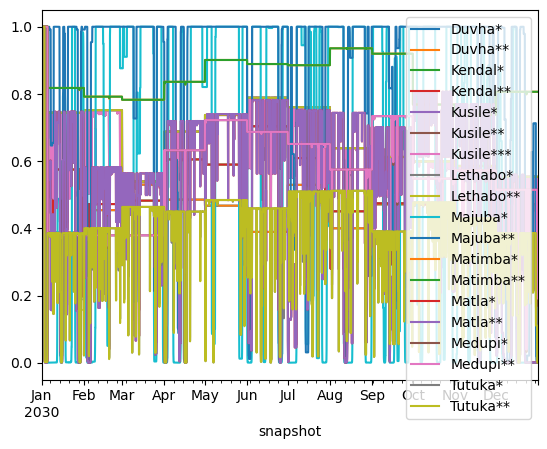

In [11]:
n_s.generators_t.status.plot()

(0.0, 35000.0)

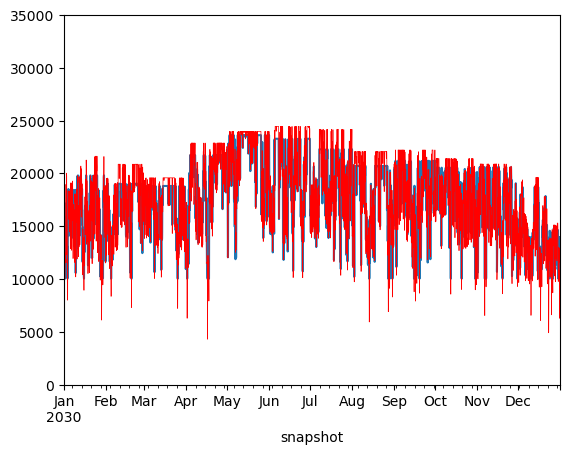

In [12]:
ax = n.generators_t.p.loc[y, n.generators.query("carrier == 'coal'").index].sum(axis=1).plot()
n_s.generators_t.p[n_s.generators.query("carrier == 'coal'").index].sum(axis=1).plot(color= 'r', lw=0.5)
ax.set_ylim(0,35000)

In [13]:
n.generators_t.p.loc[y, n.generators.query("carrier == 'coal'").index].sum().sum()/1e6 + n.generators_t.p.loc[y, n.generators.query("carrier == 'sasol_coal'").index].sum().sum()/1e6


158.3620173372673

In [14]:
n_s.generators_t.p[n_s.generators.query("carrier == 'coal'").index].sum().sum()/1e6 + n_s.generators_t.p[n_s.generators.query("carrier == 'sasol_coal'").index].sum().sum()/1e6

158.98633441357666

(0.0, 1000.0)

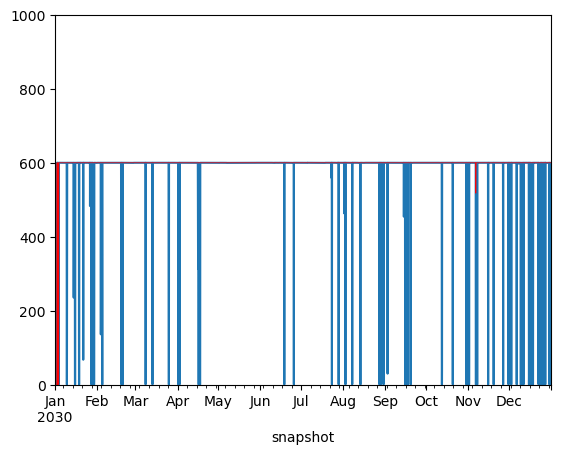

In [15]:
ax = n.generators_t.p.loc[y, n.generators.query("carrier == 'sasol_coal'").index].sum(axis=1).plot()
n_s.generators_t.p[n_s.generators.query("carrier == 'sasol_coal'").index].sum(axis=1).plot(color= 'r', lw=0.5)
ax.set_ylim(0,1000)

<Axes: xlabel='snapshot'>

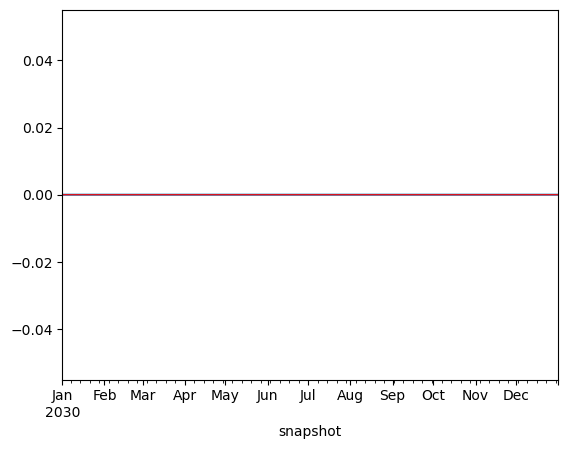

In [16]:
ax = n.generators_t.p.loc[y, n.generators.query("carrier == 'ccgt_steam'").index].sum(axis=1).plot()
n_s.generators_t.p[n_s.generators.query("carrier == 'ccgt_steam'").index].sum(axis=1).plot(color= 'r', lw=0.8)